In [ ]:
#!pip install requests asyncio bs4 nest_asyncio

In [ ]:
import requests
from bs4 import BeautifulSoup
import asyncio
from concurrent.futures import ThreadPoolExecutor
import nest_asyncio

In [ ]:
library = "http://www.perseus.tufts.edu/hopper/collection?collection=Perseus:corpus:perseus,Latin+Texts"

### Create a library

In [ ]:
r = requests.get(library).text
soup = BeautifulSoup(r,"html.parser")

In [ ]:
library_list = soup.find_all("a", {"class":"aResultsHeader"})

In [ ]:
library_urls = [i["href"] for i in library_list]

In [ ]:
library_urls

In [ ]:
library_urls

### Get all pages

##### Test

In [ ]:
"http://www.perseus.tufts.edu/hopper/"+library_urls[0]

In [ ]:
r = requests.get("http://www.perseus.tufts.edu/hopper/"+library_urls[0]).text
soup = BeautifulSoup(r,"html.parser")

In [ ]:
toc = soup.find_all("div", {"id":"toc"})[0]

In [ ]:
[ i["href"] for i in toc.find_all("a")]

##### Execution

In [ ]:
#!pipenv install nest_asyncio

In [ ]:
import asyncio
from concurrent.futures import ThreadPoolExecutor
import nest_asyncio

In [ ]:
def get_all_pieces(session, url, all_pages_urls):
    url = "http://www.perseus.tufts.edu/hopper/"+url
    r = requests.get(url).text
    soup = BeautifulSoup(r,"html.parser")
    try:
        toc = soup.find_all("div",{"id":"toc"})[0]
        toc = [i["href"] for i in toc.find_all("a")]
        all_pages_urls += toc
    except:
        print(f'ERROR url = {url}')
    

In [ ]:
async def get_index_data_asynchronous(all_pages_url, library_urls):
    """
    1. Establish an executor and number of workers
    2. Establish the session
    3. Establish the event loop
    4. Create the task by list comprenhensions
    5. Gather tasks.
    """
    with ThreadPoolExecutor(max_workers=40) as executor:
        with requests.Session() as session:
            loop = asyncio.get_event_loop()
            tasks = [
                loop.run_in_executor(
                    executor, get_all_pieces, *(session, url, all_pages_url)
                )
                for url in library_urls
            ]
            for response in await asyncio.gather(*tasks):
                pass

In [ ]:
def execute_async_index_event_loop(all_pages_url, library_urls):
    """
    This function does something analogous to compiling the get_data_asynchronously function,
    Then it executes loop.
    1. Call the get_data_function
    2. Get the event_loop
    3. Run the tasks (Much easier to understand in python 3.7, "ensure_future" was changed to "create_task")
    4. Edge_list and top_interactions will be passed to the next functions
    """
    future = asyncio.ensure_future(
        get_index_data_asynchronous(all_pages_url, library_urls)
    )
    loop = asyncio.get_event_loop()
    loop.run_until_complete(future)

In [ ]:
nest_asyncio.apply()
all_pages_url = []
execute_async_index_event_loop(all_pages_url, library_urls)

In [ ]:
all_pages_url = [i for i in all_pages_url if "javascript" not in i]

In [ ]:
all_pages_url = set(all_pages_url)

In [ ]:
len(all_pages_url)

In [ ]:
import pickle
filename = "library.pkl"
outfile = open(filename,'wb')
pickle.dump(all_pages_url, outfile)
outfile.close()

### Get all texts
##### Test

In [ ]:
import pickle
filename= "library.pkl"
infile =open(filename,'rb')
all_pages_url = pickle.load(infile)
infile.close()

In [ ]:
all_pages_url = list(all_pages_url)

In [ ]:
url = all_pages_url[1]
url = "http://www.perseus.tufts.edu/hopper/text"+url
r = requests.get(url).text
soup = BeautifulSoup(r,"html.parser")
text = soup.find_all("a",{"class":"text"})

In [ ]:
len([i.text for i in text])

In [ ]:
url

##### Execution

In [ ]:
def get_all_texts(session, base_url):
    url = "http://www.perseus.tufts.edu/hopper/text"+base_url
    r = requests.get(url).text
    soup = BeautifulSoup(r,"html.parser")
    text = soup.find_all("a",{"class":"text"})
    text = " ".join([i.text for i in text])
    f = open("texts/"+base_url,'w')
    f.write(text)
    f.close()

In [ ]:
async def get_index_data_asynchronous(all_pages_url):
    """
    1. Establish an executor and number of workers
    2. Establish the session
    3. Establish the event loop
    4. Create the task by list comprenhensions
    5. Gather tasks.
    """
    with ThreadPoolExecutor(max_workers=200) as executor:
        with requests.Session() as session:
            loop = asyncio.get_event_loop()
            tasks = [
                loop.run_in_executor(
                    executor, get_all_texts, *(session, url)
                )
                for url in all_pages_url
            ]
            for response in await asyncio.gather(*tasks):
                pass

In [ ]:
def execute_async_index_event_loop(all_pages_url):
    """
    This function does something analogous to compiling the get_data_asynchronously function,
    Then it executes loop.
    1. Call the get_data_function
    2. Get the event_loop
    3. Run the tasks (Much easier to understand in python 3.7, "ensure_future" was changed to "create_task")
    4. Edge_list and top_interactions will be passed to the next functions
    """
    future = asyncio.ensure_future(
        get_index_data_asynchronous(all_pages_url)
    )
    loop = asyncio.get_event_loop()
    loop.run_until_complete(future)

In [ ]:
%%time
nest_asyncio.apply()
all_texts = []
execute_async_index_event_loop(all_pages_url)

### Create Corpus

In [ ]:
import os

In [ ]:
len(os.listdir("texts/"))

In [ ]:
docs = ["texts/"+i for i in os.listdir("texts/")]

In [ ]:
o = open(docs[0])
o = o.read()

In [ ]:
[ i.strip('\n') for i in o.split(" ")]

In [ ]:
def doc_stream(path):
    for f in os.listdir(path):
        with open(os.path.join(path,f)) as t:
            text = t.read()
            text = [ i.strip('\n') for i in text.split(" ")]
            yield text

In [ ]:
!pip install gensim

In [ ]:
from gensim import corpora
dictionary = corpora.dictionary.Dictionary()

In [ ]:
ds = doc_stream("texts/")

In [ ]:
latin_dict = corpora.Dictionary(ds)

In [ ]:
latin_dict.save("latin_gensim_dict")

In [ ]:
keys = latin_dict.cfs.keys()
values = latin_dict.cfs.values()
word = [latin_dict[i] for i in keys]

In [ ]:
import pandas as pd

In [ ]:
df = pd.DataFrame()

In [ ]:
df["word"] = word

In [ ]:
df["frequency"] = values

In [ ]:
df.sort_values("frequency",ascending=False,inplace=True)

In [ ]:
df["percent_of_corpus"] = df["frequency"] / latin_dict.num_pos

In [ ]:
df.head()

In [ ]:
from gensim.models.phrases import Phrases

In [ ]:
bigrams = Phrases(doc_stream("texts/")) 

In [ ]:
bigrams.vocab

In [ ]:
trigrams = Phrases(bigrams[doc_stream("texts/")])

In [ ]:
t = trigrams.vocab

In [ ]:
keys = t.keys()
values = t.values()

In [ ]:
df2 = pd.DataFrame()

In [ ]:
keys = [i.decode("UTF-8") for i in keys]
keys = [i.split("_") for i in keys]
keys = [" ".join(i) for i in keys]

In [ ]:
df2["phrases"] = keys
df2["values"] = values

In [ ]:
df2.sort_values("values",ascending=False, inplace=True)

In [ ]:
df2["values"].plot()

In [ ]:
import pickle

In [ ]:
filename = "df2.pkl"
outfile = open(filename,'wb')
pickle.dump(df2, outfile)
outfile.close()

### Data Transformation

In [1]:
#!pipenv install seaborn

In [2]:
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import seaborn as sns

In [3]:
import pickle
filename= "df2.pkl"
infile =open(filename,'rb')
df2 = pickle.load(infile)
infile.close()

In [4]:
useful_values = df2[df2["values"]>500]

In [5]:
useful_values

,phrases,values
15,et,193169
63,in,103819
1,est,67748
82,non,59465
9,ut,52925
...,...,...
8058,quom,502
262,ad modum,502
8781,quia non,501
5795,templum,501


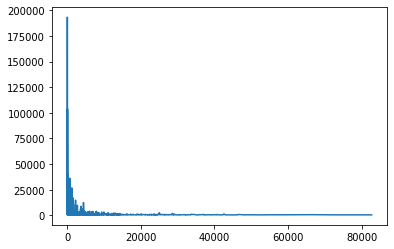

In [6]:
sns.lineplot(data=useful_values["values"])

In [7]:
df2["len"]= df2["phrases"].apply(lambda x: len(x.split(" ")))

In [8]:
num_words = df2["values"].sum()

In [10]:
df2["percent"] = df2["values"] / num_words

In [12]:
df2["zipf"] = df2["percent"].cumsum()

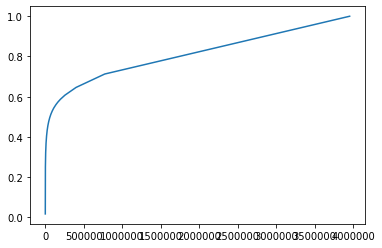

In [18]:
plt.plot(df2["zipf"].values)

### Unigram

In [23]:
words_df = df2[df2["len"]==1]

In [25]:
num_words = words_df["values"].sum()
words_df["percent"] = words_df["values"]/num_words
words_df["zipf"] = words_df["percent"].cumsum()

/home/cwcollins/.local/share/virtualenvs/latin_project-iWf3JHF9/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/cwcollins/.local/share/virtualenvs/latin_project-iWf3JHF9/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


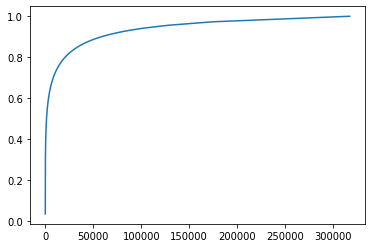

In [30]:
plt.plot(words_df["zipf"].values)

In [52]:
words_df[words_df["zipf"]<=.5].count()

phrases    1269
values     1269
len        1269
percent    1269
zipf       1269
dtype: int64

In [33]:
words_df[words_df["zipf"]<=.6].count()

phrases    3325
values     3325
len        3325
percent    3325
zipf       3325
dtype: int64

In [54]:
words_df[words_df["zipf"]<=.65].count()

phrases    5258
values     5258
len        5258
percent    5258
zipf       5258
dtype: int64

In [32]:
words_df[words_df["zipf"]<=.8].count()

phrases    20549
values     20549
len        20549
percent    20549
zipf       20549
dtype: int64

In [51]:
words_df[words_df["zipf"]<=.6]

,phrases,values,len,percent,zipf
15,et,193169,1,0.036658,0.036658
63,in,103819,1,0.019702,0.056360
1,est,67748,1,0.012857,0.069217
82,non,59465,1,0.011285,0.080502
9,ut,52925,1,0.010044,0.090546
...,...,...,...,...,...
6477,negoti,170,1,0.000032,0.599862
38588,argumento,170,1,0.000032,0.599895
1620,haut,170,1,0.000032,0.599927
4795,subiecta,170,1,0.000032,0.599959


### bigram

In [34]:
bigram = df2[df2["len"]==2]
num_words = bigram["values"].sum()
bigram["percent"] = bigram["values"]/num_words
bigram["zipf"] = bigram["percent"].cumsum()

/home/cwcollins/.local/share/virtualenvs/latin_project-iWf3JHF9/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/cwcollins/.local/share/virtualenvs/latin_project-iWf3JHF9/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


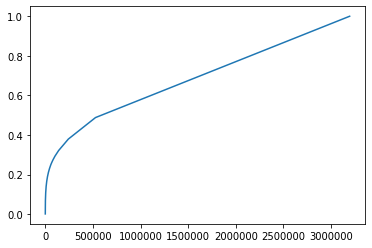

In [38]:
plt.plot(bigram["zipf"].values)

In [45]:
top_bigrams = bigram[bigram["zipf"]<=.1]

In [48]:
top_bigrams[0:40]

,phrases,values,len,percent,zipf
2536,et in,5177,2,0.000994,0.000994
2833,id est,3241,2,0.000622,0.001616
598,non est,2606,2,0.000500,0.002116
3732,est et,2546,2,0.000489,0.002605
6984,et non,1955,2,0.000375,0.002980
14307,et cum,1834,2,0.000352,0.003332
1199,est in,1818,2,0.000349,0.003681
1416,est quod,1817,2,0.000349,0.004029
1384,est ut,1699,2,0.000326,0.004355
4905,in quo,1698,2,0.000326,0.004681


### Trigrams

In [55]:
trigram = df2[df2["len"]==3]
num_words = trigram["values"].sum()
trigram["percent"] = trigram["values"]/num_words
trigram["zipf"] = trigram["percent"].cumsum()

/home/cwcollins/.local/share/virtualenvs/latin_project-iWf3JHF9/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/cwcollins/.local/share/virtualenvs/latin_project-iWf3JHF9/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


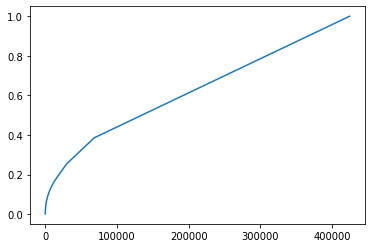

In [56]:
plt.plot(trigram["zipf"].values)

In [58]:
top_trigrams = trigram[trigram["zipf"]<=.1]

In [62]:
trigram[trigram["zipf"]<=.1].count()

phrases    4194
values     4194
len        4194
percent    4194
zipf       4194
dtype: int64

In [61]:
top_trigrams[:40]

,phrases,values,len,percent,zipf
263,quem ad modum,481,3,0.000830,0.000830
4100,quam ob rem,407,3,0.000702,0.001532
46954,in re publica,252,3,0.000435,0.001967
4052,de re publica,217,3,0.000374,0.002341
23927,et factum est,198,3,0.000342,0.002682
2809,ab eo quod,197,3,0.000340,0.003022
23472,haec dicit Dominus,136,3,0.000235,0.003257
34050,in die illa,136,3,0.000235,0.003491
44828,ut supra diximus,125,3,0.000216,0.003707
253916,ex eo quod,121,3,0.000209,0.003916
